In [2]:
# make the imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal

# Monkey Resting ECoG Data
Recorded from monkey whole cortex. ECoG sampled at 1000Hz, 3 channels. From **Yanagawa et al., PLOS ONE, 2013.**

In this experiment, the monkey is sitting in a chair with no task demands. 5 minutes of data each are provided during 3 different stages: awake eyes open, awake eyes closed, and anesthesized. They are stored in `ecog_eyesopen`,`ecog_eyesclosed`, and `ecog_anes` respectively. The sampling rate is provided, from which you can compute the time vectors (they can have their own time vectors all starting from 0s).

`labels` contains information about which brain regions the 3 channels are located in, while `elec_num` has the electrode number, which you can find on the brain map image included in the same folder (brainmap.jpg).

dict_keys(['__header__', '__version__', '__globals__', 'ecog_anes', 'ecog_eyesclosed', 'ecog_eyesopen', 'elec_num', 'fs', 'labels'])
1000
(3, 300000)
['cingulate' 'occipital' 'temporal']
[52 70 91]


/Users/daniellew/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/daniellew/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


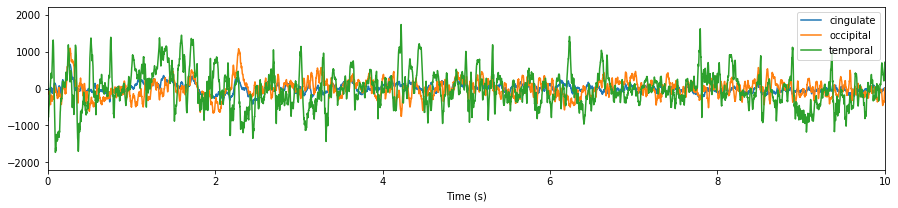

In [3]:
monkey_ecog_data = io.loadmat('ECoG_monkey/ECoG_monkey.mat', squeeze_me = True)
print(monkey_ecog_data.keys())
print(monkey_ecog_data['fs'])
print(monkey_ecog_data['ecog_eyesopen'].shape)
print(monkey_ecog_data['labels'])
print(monkey_ecog_data['elec_num'])

plt.figure(figsize=(15,3))
plt.plot(np.arange(0,monkey_ecog_data['ecog_eyesopen'].shape[1]/monkey_ecog_data['fs'],1/monkey_ecog_data['fs']), 
         monkey_ecog_data['ecog_eyesopen'].T)
plt.xlim([0,10])
plt.xlabel('Time (s)')
plt.legend(monkey_ecog_data['labels'])

Here we initialize variables to grab the Eyes Open, Eyes Closed and Sleeping monkey data from the ECoG Monkey Data signal. We also use created five bandpass filters for the five brain wave functions we will be using, each of which corresponds to that wave's respective frequency ranges.

In [4]:
fs = monkey_ecog_data['fs']
print('Sampling rate = %iHz'%fs)
print(monkey_ecog_data['elec_num'])
eyesopenLFP = monkey_ecog_data['ecog_eyesopen'][1,:]/1000
eyesclosedLFP = monkey_ecog_data['ecog_eyesclosed'][1,:]/1000
sleepingMonkeyLFP = monkey_ecog_data['ecog_anes'][1,:]/1000

t_Open = np.arange(0, len(eyesopenLFP)/fs, 1/fs)
t_Closed = np.arange(0, len(eyesclosedLFP)/fs, 1/fs)
t_Sleep = np.arange(0, len(sleepingMonkeyLFP)/fs, 1/fs)


FIR_theta = signal.firwin(751, fs=fs, cutoff = [4,10], pass_zero = False) 
FIR_gamma = signal.firwin(751, fs=fs, cutoff = [30,50], pass_zero = False) 
FIR_alpha = signal.firwin(751, fs=fs, cutoff = [6,12], pass_zero = False) 
FIR_beta = signal.firwin(751, fs=fs, cutoff = [12.5,30], pass_zero = False)
FIR_delta = signal.firwin(751, fs=fs, cutoff = [0.5,4], pass_zero = False)

Sampling rate = 1000Hz
[52 70 91]


# PSD
We are first going to create the PSD graphs with the three channels for each of the three brain areas.

In [10]:
#Sleep for each of the three labels
anes0 = monkey_ecog_data['ecog_anes'][0,:]/1000
anes1 = monkey_ecog_data['ecog_anes'][1,:]/1000
anes2 = monkey_ecog_data['ecog_anes'][2,:]/1000

#Eyes closed for each of the three labels
eyesclosed0 = monkey_ecog_data['ecog_eyesclosed'][0,:]/1000
eyesclosed1 = monkey_ecog_data['ecog_eyesclosed'][1,:]/1000
eyesclosed2 = monkey_ecog_data['ecog_eyesclosed'][2,:]/1000

#Eyes Open for each of the three labels
eyesopen0 = monkey_ecog_data['ecog_eyesopen'][0,:]/1000
eyesopen1 = monkey_ecog_data['ecog_eyesopen'][1,:]/1000
eyesopen2 = monkey_ecog_data['ecog_eyesopen'][2,:]/1000

In [11]:
def plot_spectrogram(spg, t, f, freq_lims=[0,100], plot_db=False):
    """
    Utility function for plotting the spectrogram for you.
    
    spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
    t: time axis of spectrogram
    f: frequency axis of spectrogram
    freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
    """
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time (s)'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

def slide_window_time(T,len_win,len_overlap):
    # T is total signal time, len_win is window length in seconds, len_overlap is overlap length i
    t_steps = np.arange(0,T,(len_win-len_overlap))
    return t_steps[t_steps<=(T-len_win)]

def slide_window_index(T,fs,len_win,len_overlap):
    return np.round((slide_window_time(T,len_win,len_overlap)*fs).astype(int))

def compute_pwsp(sig, fs):
    pwsp = np.abs(np.fft.fft(sig))**2
    freqs = np.fft.fftfreq(len(sig), 1/fs)
    return pwsp, freqs

def plot_pwsp(freqs, pwsp):
    plt.loglog(freqs, pwsp, '-')
    plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (V^2)')
    
def my_stft(data, fs, len_win, len_overlap):
    T = len(data)/fs
    inds_stft = slide_window_index(T, fs, len_win, len_overlap)
    t_stft = slide_window_time(T, len_win, len_overlap)
    f_stft = np.fft.fftfreq(int(fs*len_win), 1/fs)
    stft = np.array([np.fft.fft(data[i:i+int(fs*len_win)]) for i in inds_stft]).T
    
    # clip the frequency axis to return just the non-negative frequencies
    # np.fft.fftfreq returns the nyquist frequency as negative, which we also need to keep
    
    positive_fs = np.logical_or(f_stft>=0, f_stft==-fs/2)
    # I return for you just the positive frequencies
    return abs(f_stft[positive_fs]), t_stft, stft[positive_fs, :]

# Eyes Open PSD

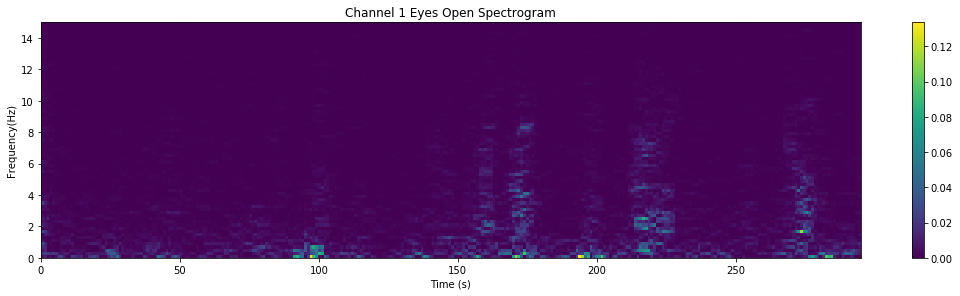

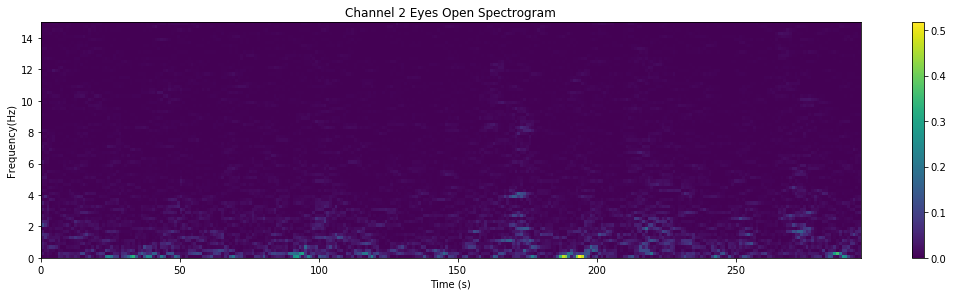

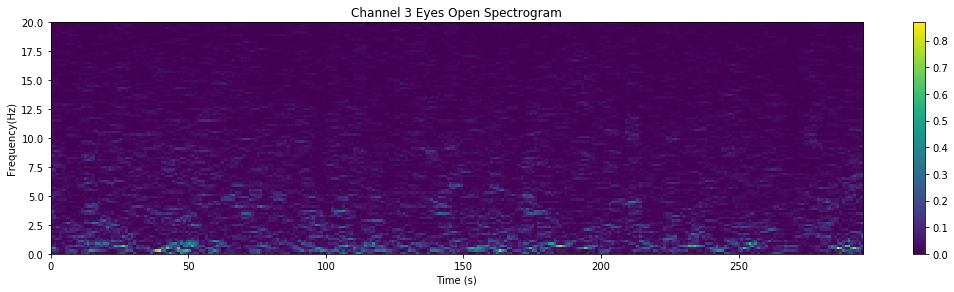

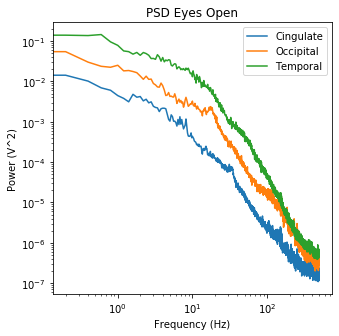

In [88]:
len_win = 5
len_overlap = 4

#Chan 0 Cingulate
f_stft0, t_stft0, stft0 = my_stft(eyesopen0, fs, len_win, len_overlap)
spg0 = abs(stft0/fs)**2
psd0 = spg0.mean(axis=1)

#Chan 1 Occipital
f_stft1, t_stft1, stft1 = my_stft(eyesopen1, fs, len_win, len_overlap)
spg1 = abs(stft1/fs)**2
psd1 = spg1.mean(axis=1)

#Chan 2 Temporal
f_stft2, t_stft2, stft2 = my_stft(eyesopen2, fs, len_win, len_overlap)
spg2 = abs(stft2/fs)**2
psd2 = spg2.mean(axis=1)


# use plot_spectrogram
plot_spectrogram(spg0, t_stft0, f_stft0, plot_db=False, freq_lims=[0,15])
plt.title('Channel 1 Eyes Open Spectrogram')
plot_spectrogram(spg1, t_stft1, f_stft1, plot_db=False, freq_lims=[0,15])
plt.title('Channel 2 Eyes Open Spectrogram')
plot_spectrogram(spg2, t_stft2, f_stft2, plot_db=False, freq_lims=[0,20])
plt.title('Channel 3 Eyes Open Spectrogram')

# plot the PSD
plt.figure(figsize=(5,5))
plt.loglog(f_stft0, psd0, label = 'Cingulate')
plt.loglog(f_stft1, psd1, label = 'Occipital')
plt.loglog(f_stft2, psd2, label = 'Temporal')
plt.title('PSD Eyes Open')
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (V^2)')
plt.legend()

# Eyes Closed PSD

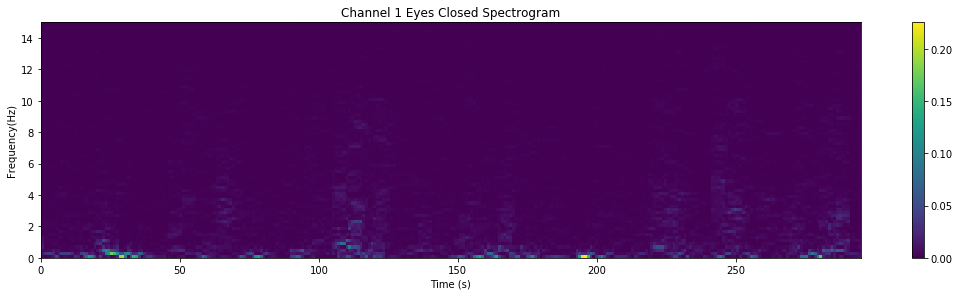

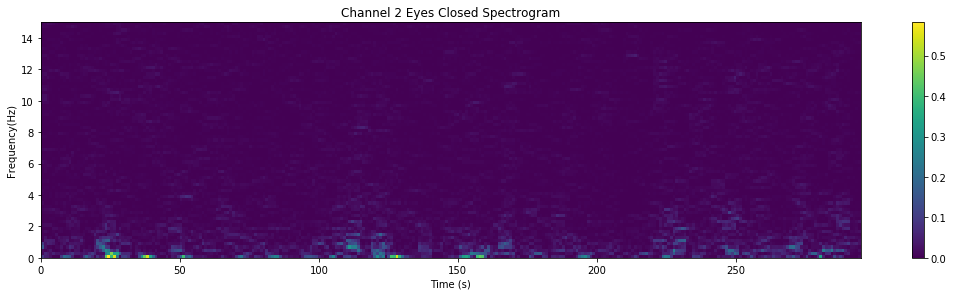

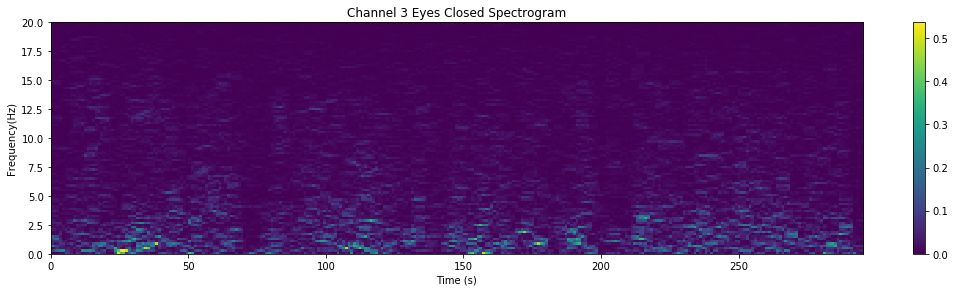

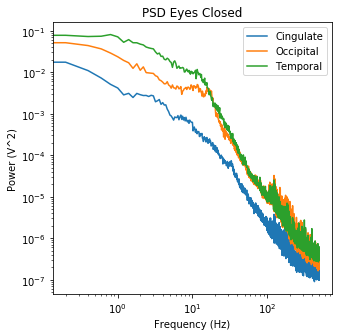

In [87]:
len_win = 5
len_overlap = 4

#Chan 0 Cingulate
f_stft0, t_stft0, stft0 = my_stft(eyesclosed0, fs, len_win, len_overlap)
spg0 = abs(stft0/fs)**2
psd0 = spg0.mean(axis=1)

#Chan 1 Occipital
f_stft1, t_stft1, stft1 = my_stft(eyesclosed1, fs, len_win, len_overlap)
spg1 = abs(stft1/fs)**2
psd1 = spg1.mean(axis=1)

#Chan 2 Temporal
f_stft2, t_stft2, stft2 = my_stft(eyesclosed2, fs, len_win, len_overlap)
spg2 = abs(stft2/fs)**2
psd2 = spg2.mean(axis=1)


# use plot_spectrogram
plot_spectrogram(spg0, t_stft0, f_stft0, plot_db=False, freq_lims=[0,15])
plt.title('Channel 1 Eyes Closed Spectrogram')
plot_spectrogram(spg1, t_stft1, f_stft1, plot_db=False, freq_lims=[0,15])
plt.title('Channel 2 Eyes Closed Spectrogram')
plot_spectrogram(spg2, t_stft2, f_stft2, plot_db=False, freq_lims=[0,20])
plt.title('Channel 3 Eyes Closed Spectrogram')

# plot the PSD
plt.figure(figsize=(5,5))
plt.loglog(f_stft0, psd0, label = 'Cingulate')
plt.loglog(f_stft1, psd1, label = 'Occipital')
plt.loglog(f_stft2, psd2, label = 'Temporal')
plt.title('PSD Eyes Closed')
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (V^2)')
plt.legend()

# Sleep PSD

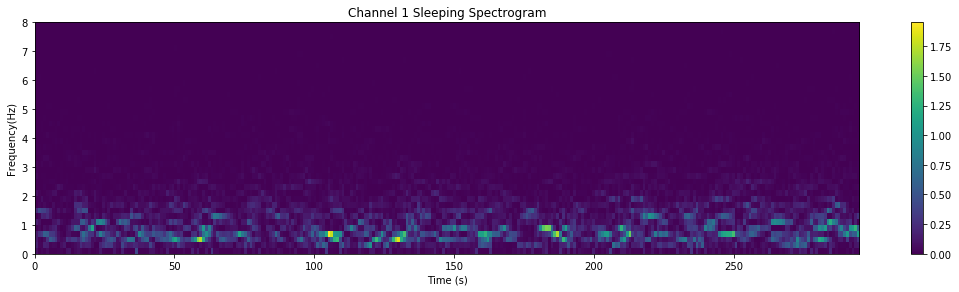

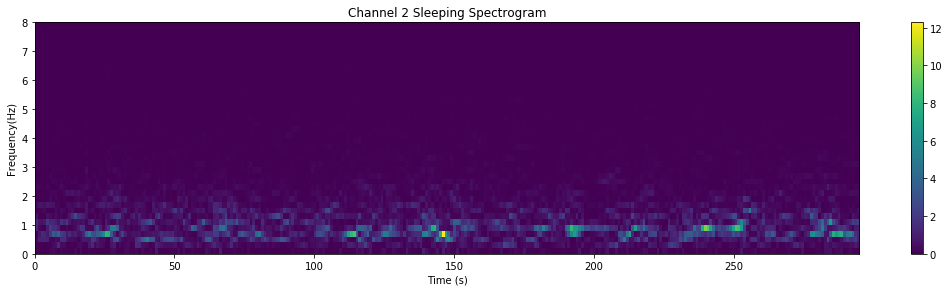

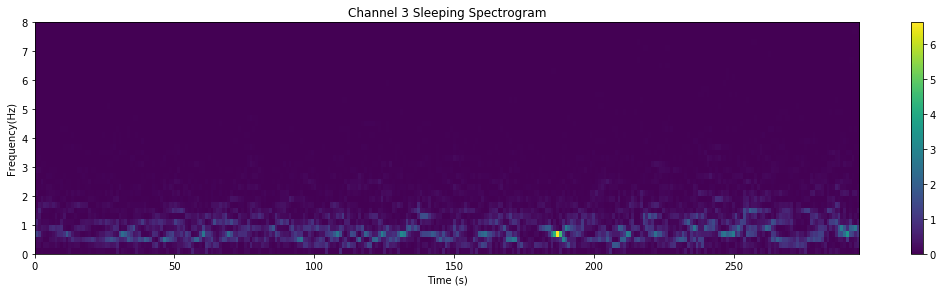

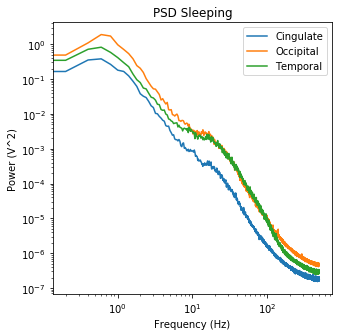

In [89]:
len_win = 5
len_overlap = 4

#Chan 0 Cingulate
f_stft0, t_stft0, stft0 = my_stft(anes0, fs, len_win, len_overlap)
spg0 = abs(stft0/fs)**2
psd0 = spg0.mean(axis=1)

#Chan 1 Occipital
f_stft1, t_stft1, stft1 = my_stft(anes1, fs, len_win, len_overlap)
spg1 = abs(stft1/fs)**2
psd1 = spg1.mean(axis=1)

#Chan 2 Temporal
f_stft2, t_stft2, stft2 = my_stft(anes2, fs, len_win, len_overlap)
spg2 = abs(stft2/fs)**2
psd2 = spg2.mean(axis=1)


# use plot_spectrogram
plot_spectrogram(spg0, t_stft0, f_stft0, plot_db=False, freq_lims=[0,8])
plt.title('Channel 1 Sleeping Spectrogram')
plot_spectrogram(spg1, t_stft1, f_stft1, plot_db=False, freq_lims=[0,8])
plt.title('Channel 2 Sleeping Spectrogram')
plot_spectrogram(spg2, t_stft2, f_stft2, plot_db=False, freq_lims=[0,8])
plt.title('Channel 3 Sleeping Spectrogram')

# plot the PSD
plt.figure(figsize=(5,5))
plt.loglog(f_stft0, psd0, label = 'Cingulate')
plt.loglog(f_stft1, psd1, label = 'Occipital')
plt.loglog(f_stft2, psd2, label = 'Temporal')
plt.title('PSD Sleeping')
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (V^2)')
plt.legend()

# Hilbert Transform

We then create oscillation wave variables for each of the five waves with the bandpass filter we created for three channels of signal data: Eyes Open, Eyes Closed and Sleeping. This provides us with fifteen variables of data we will be using to look at the ECoG data.

In [18]:
theta_oscOpen = np.convolve(eyesopenLFP, FIR_theta, mode= 'same')
theta_oscClosed = np.convolve(eyesclosedLFP, FIR_theta, mode= 'same')
theta_oscSleep = np.convolve(sleepingMonkeyLFP, FIR_theta, mode= 'same')

gamma_oscOpen = np.convolve(eyesopenLFP, FIR_gamma, mode= 'same')
gamma_oscClosed = np.convolve(eyesclosedLFP, FIR_gamma, mode= 'same')
gamma_oscSleep = np.convolve(sleepingMonkeyLFP, FIR_gamma, mode= 'same')

beta_oscOpen = np.convolve(eyesopenLFP, FIR_beta, mode= 'same')
beta_oscClosed = np.convolve(eyesclosedLFP, FIR_beta, mode= 'same')
beta_oscSleep = np.convolve(sleepingMonkeyLFP, FIR_beta, mode= 'same')

alpha_oscOpen = np.convolve(eyesopenLFP, FIR_alpha, mode= 'same')
alpha_oscClosed = np.convolve(eyesclosedLFP, FIR_alpha, mode= 'same')
alpha_oscSleep = np.convolve(sleepingMonkeyLFP, FIR_alpha, mode= 'same')

delta_oscOpen = np.convolve(eyesopenLFP, FIR_delta, mode= 'same')
delta_oscClosed = np.convolve(eyesclosedLFP, FIR_delta, mode= 'same')
delta_oscSleep = np.convolve(sleepingMonkeyLFP, FIR_delta, mode= 'same')

Finally we used those fifteen oscillation channels and used the hilbert transform

In [19]:
x_a_thetaOpen = signal.hilbert(theta_oscOpen)
x_a_thetaClosed = signal.hilbert(theta_oscClosed)
x_a_thetaSleep = signal.hilbert(theta_oscSleep)

x_a_gammaOpen = signal.hilbert(gamma_oscOpen)
x_a_gammaClosed = signal.hilbert(gamma_oscClosed)
x_a_gammaSleep = signal.hilbert(gamma_oscSleep)

x_a_betaOpen = signal.hilbert(beta_oscOpen)
x_a_betaClosed = signal.hilbert(beta_oscClosed)
x_a_betaSleep = signal.hilbert(beta_oscSleep)

x_a_alphaOpen = signal.hilbert(alpha_oscOpen)
x_a_alphaClosed = signal.hilbert(alpha_oscClosed)
x_a_alphaSleep = signal.hilbert(alpha_oscSleep)

x_a_deltaOpen = signal.hilbert(delta_oscOpen)
x_a_deltaClosed = signal.hilbert(delta_oscClosed)
x_a_deltaSleep = signal.hilbert(delta_oscSleep)


Then using the hilbert transform variables we created above for the five waves, with three different channels each, we computed their power and phase variables to use for our analysis

In [20]:

def compute_power_phase(x_a):
    power = np.abs(x_a)**2
    phase = np.angle(x_a)
    return power, phase


In [21]:
theta_powerOpen, theta_phaseOpen = compute_power_phase(x_a_thetaOpen)
theta_powerClosed, theta_phaseClosed = compute_power_phase(x_a_thetaClosed)
theta_powerSleep, theta_phaseSleep = compute_power_phase(x_a_thetaSleep)

gamma_powerOpen, gamma_phaseOpen = compute_power_phase(x_a_gammaOpen)
gamma_powerClosed, gamma_phaseClosed = compute_power_phase(x_a_gammaClosed)
gamma_powerSleep, gamma_phaseSleep = compute_power_phase(x_a_gammaSleep)

alpha_powerOpen, alpha_phaseOpen = compute_power_phase(x_a_alphaOpen)
alpha_powerClosed, alpha_phaseClosed = compute_power_phase(x_a_alphaClosed)
alpha_powerSleep, alpha_phaseSleep = compute_power_phase(x_a_alphaSleep)

beta_powerOpen, beta_phaseOpen = compute_power_phase(x_a_betaOpen)
beta_powerClosed, beta_phaseClosed = compute_power_phase(x_a_betaClosed)
beta_powerSleep, beta_phaseSleep = compute_power_phase(x_a_betaSleep)

delta_powerOpen, delta_phaseOpen = compute_power_phase(x_a_deltaOpen)
delta_powerClosed, delta_phaseClosed = compute_power_phase(x_a_deltaClosed)
delta_powerSleep, delta_phaseSleep = compute_power_phase(x_a_deltaSleep)

Here we plotted the Eyes open power for all five brain waves in order to look at the activity of each wave during this one state

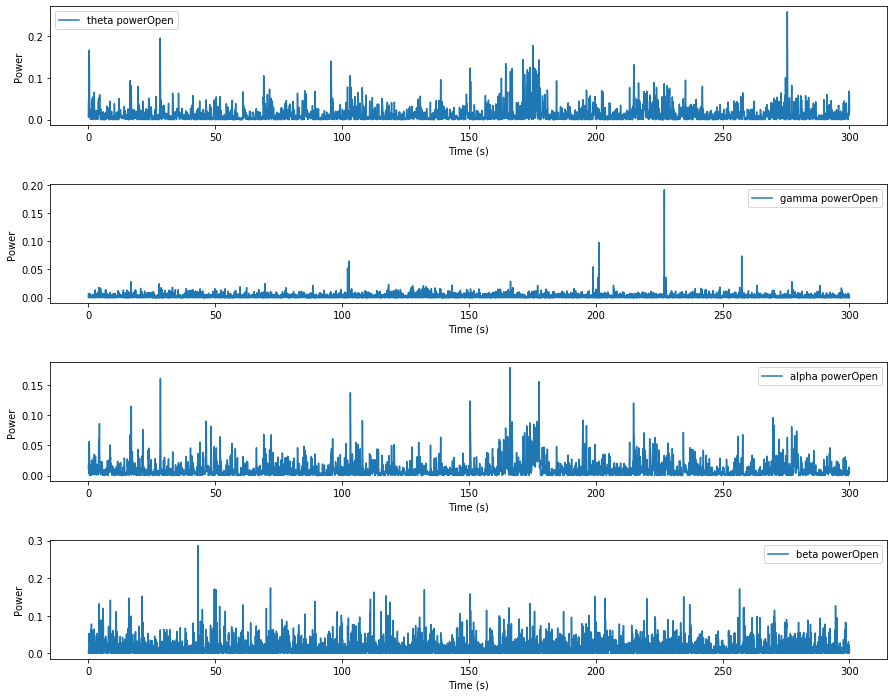

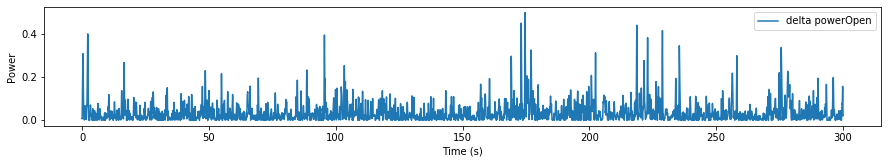

In [25]:
# Eyes open instantaneous power
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

# theta power
plt.subplot(4,1,1)
plt.plot(t_Open, theta_powerOpen, label = 'theta powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# gamma power
plt.subplot(4,1,2)
plt.plot(t_Open, gamma_powerOpen, label = 'gamma powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# alpha power
plt.subplot(4,1,3)
plt.plot(t_Open, alpha_powerOpen, label = 'alpha powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# beta power
plt.subplot(4,1,4)
plt.plot(t_Open, beta_powerOpen, label = 'beta powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# delta power
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)
plt.subplot(4,1,4)
plt.plot(t_Open, delta_powerOpen, label = 'delta powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

Here we plotted the Eyes closed power for all five brain waves in order to look at the activity of each wave during this one state

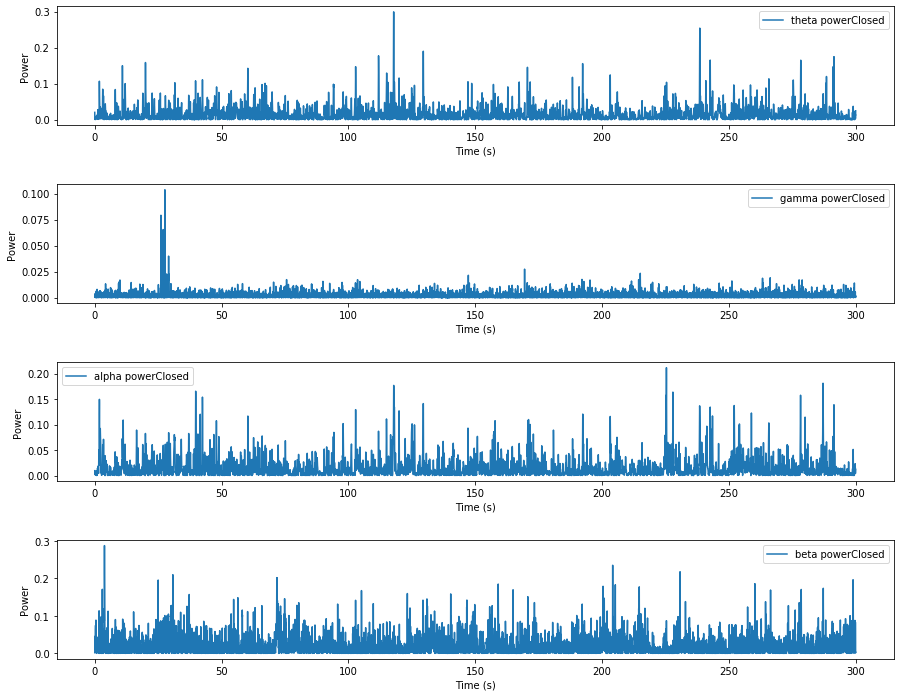

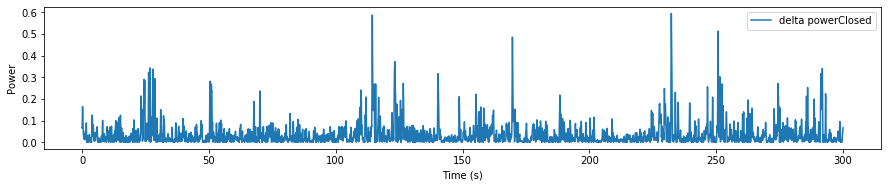

In [26]:
# Eyes closed power
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

# Theta
plt.subplot(4,1,1)
plt.plot(t_Open, theta_powerClosed, label = 'theta powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Gamma
plt.subplot(4,1,2)
plt.plot(t_Open, gamma_powerClosed, label = 'gamma powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Alpha
plt.subplot(4,1,3)
plt.plot(t_Open, alpha_powerClosed, label = 'alpha powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Beta
plt.subplot(4,1,4)
plt.plot(t_Open, beta_powerClosed, label = 'beta powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# delta power
plt.figure(figsize=(15,12))
plt.subplot(4,1,4)
plt.plot(t_Open, delta_powerClosed, label = 'delta powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

Here we plotted the Eyes closed power for all five brain waves in order to look at the activity of each wave during this one state


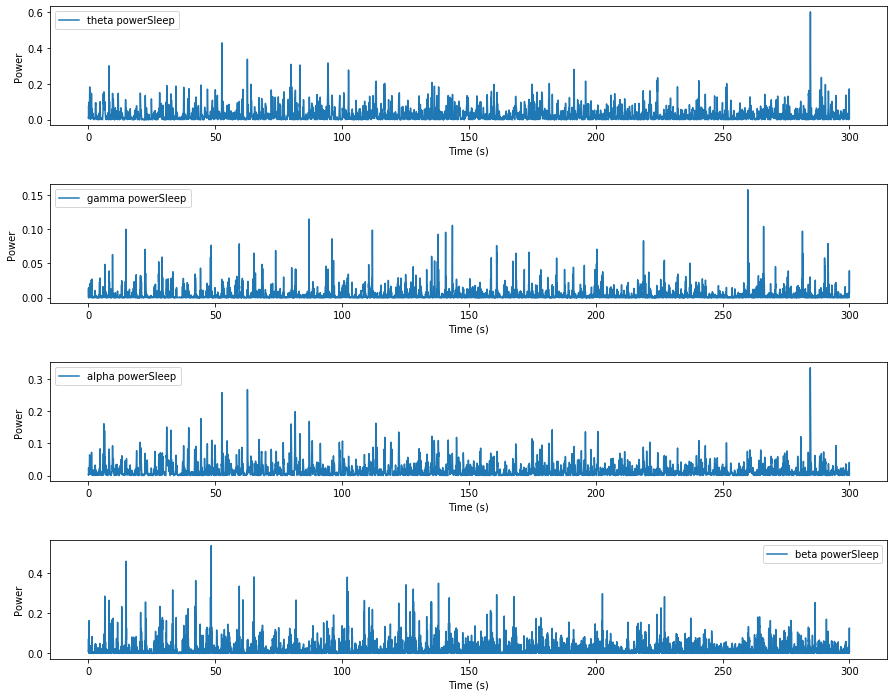

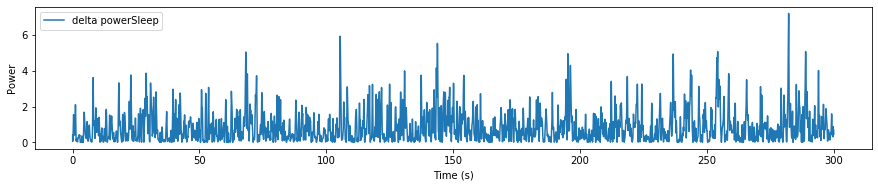

In [28]:
# Eyes sleep Power
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

# Theta
plt.subplot(4,1,1)
plt.plot(t_Open, theta_powerSleep, label = 'theta powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Gamma
plt.subplot(4,1,2)
plt.plot(t_Open, gamma_powerSleep, label = 'gamma powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Alpha
plt.subplot(4,1,3)
plt.plot(t_Open, alpha_powerSleep, label = 'alpha powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Beta
plt.subplot(4,1,4)
plt.plot(t_Open, beta_powerSleep, label = 'beta powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# delta power
plt.figure(figsize=(15,12))
plt.subplot(4,1,4)
plt.plot(t_Open, delta_powerSleep, label = 'delta powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

Finally here we grouped each of the individual powers together by brain wave. This allows for a better analysis of which brain wave is the most prominent in each specific channel. Thus, the powers for each of the five brain waves were group together based on if it was the power related to sleeping, eyes closed, or eyes open

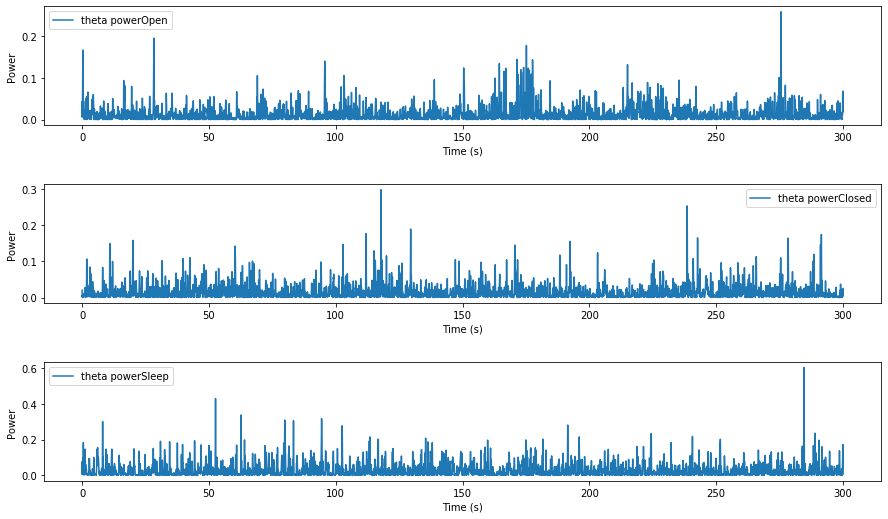

In [15]:
# Theta Powers
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

# Eyes Open
plt.subplot(4,1,1)
plt.plot(t_Open, theta_powerOpen, label = 'theta powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Closed
plt.subplot(4,1,2)
plt.plot(t_Open, theta_powerClosed, label = 'theta powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Sleep
plt.subplot(4,1,3)
plt.plot(t_Open, theta_powerSleep, label = 'theta powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

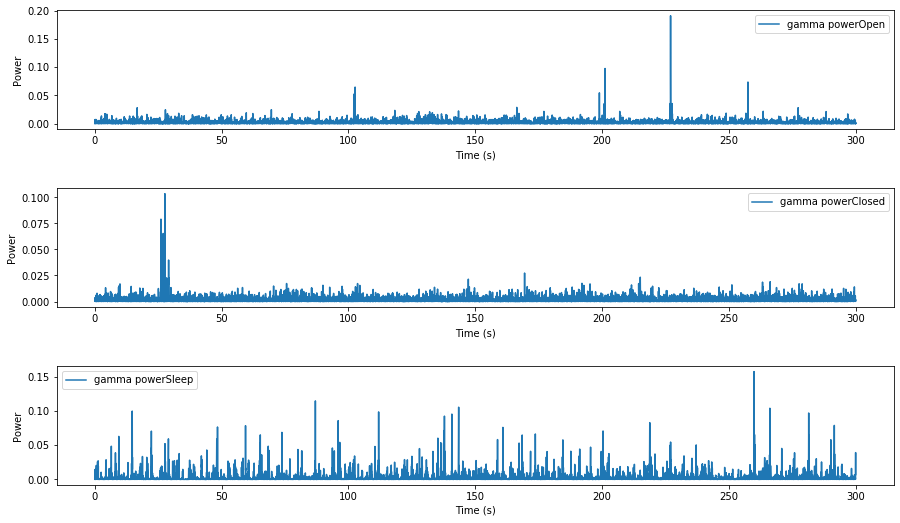

In [29]:
# Gamma Powers
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

# Eyes Open
plt.subplot(4,1,1)
plt.plot(t_Open, gamma_powerOpen, label = 'gamma powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Closed
plt.subplot(4,1,2)
plt.plot(t_Open, gamma_powerClosed, label = 'gamma powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Sleep
plt.subplot(4,1,3)
plt.plot(t_Open, gamma_powerSleep, label = 'gamma powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

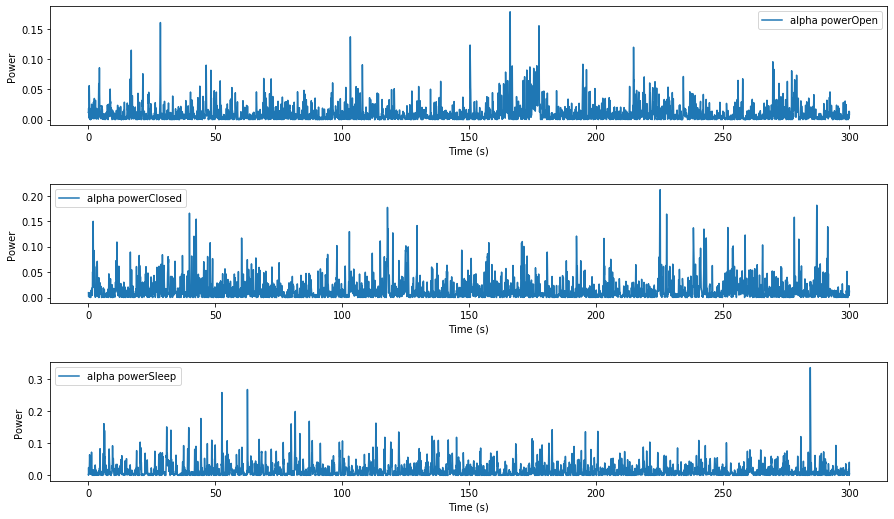

In [30]:
# Alpha Powers
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

# Eyes Open
plt.subplot(4,1,1)
plt.plot(t_Open, alpha_powerOpen, label = 'alpha powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Closed
plt.subplot(4,1,2)
plt.plot(t_Open, alpha_powerClosed, label = 'alpha powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Sleep
plt.subplot(4,1,3)
plt.plot(t_Open, alpha_powerSleep, label = 'alpha powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

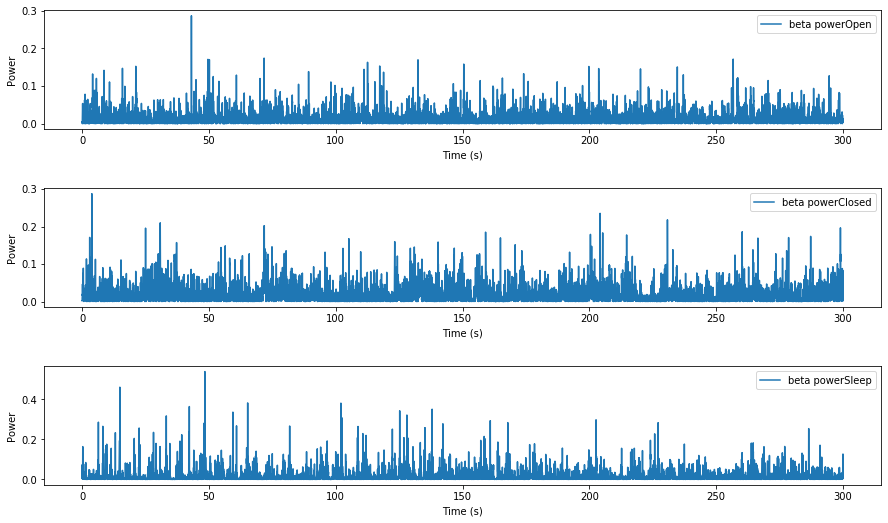

In [31]:
# Beta Powers
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

# Eyes Open
plt.subplot(4,1,1)
plt.plot(t_Open, beta_powerOpen, label = 'beta powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Closed
plt.subplot(4,1,2)
plt.plot(t_Open, beta_powerClosed, label = 'beta powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Sleep
plt.subplot(4,1,3)
plt.plot(t_Open, beta_powerSleep, label = 'beta powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

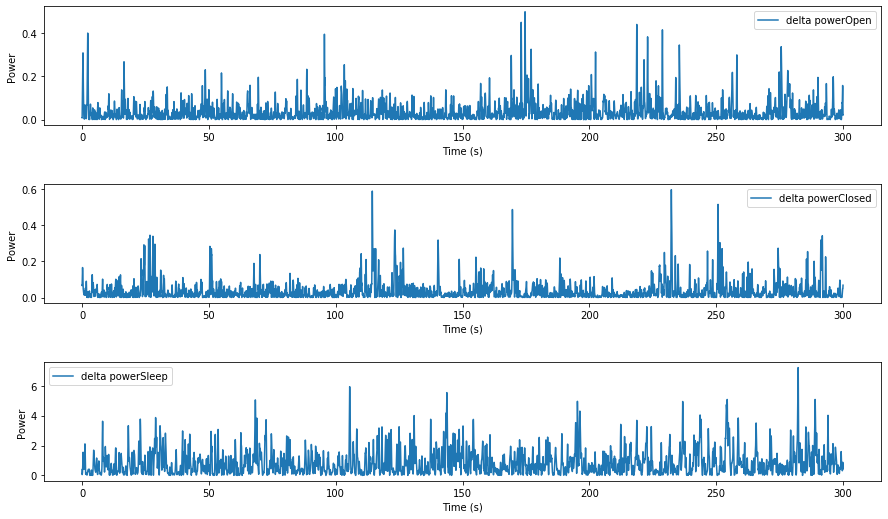

In [32]:
# Delta Powers
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

# Eyes Open
plt.subplot(4,1,1)
plt.plot(t_Open, delta_powerOpen, label = 'delta powerOpen')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Closed
plt.subplot(4,1,2)
plt.plot(t_Open, delta_powerClosed, label = 'delta powerClosed')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# Eyes Sleep
plt.subplot(4,1,3)
plt.plot(t_Open, delta_powerSleep, label = 'delta powerSleep')
plt.xlabel('Time (s)'); plt.ylabel('Power')
plt.legend()

# PHASE AMPLITUDE COUPLING  BEGINS

Now we wanted to see if there was any phase amplitude coupling between the peaks and troughs of each specific brain wave. First we calculate these peaks and troughs for all five brain waves, and do the same for each of the three channels

In [39]:
thetapeak_indsOpen = np.where(np.logical_and(theta_phaseOpen>-np.pi/2, theta_phaseOpen<np.pi/2))[0]
thetatrough_indsOpen = np.where(np.logical_or(theta_phaseOpen<-np.pi/2, theta_phaseOpen>np.pi/2))[0]

gammapeak_indsOpen = np.where(np.logical_and(gamma_phaseOpen>-np.pi/2, gamma_phaseOpen<np.pi/2))[0]
gammatrough_indsOpen = np.where(np.logical_or(gamma_phaseOpen<-np.pi/2, gamma_phaseOpen>np.pi/2))[0]

alphapeak_indsOpen = np.where(np.logical_and(alpha_phaseOpen>-np.pi/2, alpha_phaseOpen<np.pi/2))[0]
alphatrough_indsOpen = np.where(np.logical_or(alpha_phaseOpen<-np.pi/2, alpha_phaseOpen>np.pi/2))[0]

betapeak_indsOpen = np.where(np.logical_and(beta_phaseOpen>-np.pi/2, beta_phaseOpen<np.pi/2))[0]
betatrough_indsOpen = np.where(np.logical_or(beta_phaseOpen<-np.pi/2, beta_phaseOpen>np.pi/2))[0]

deltapeak_indsOpen = np.where(np.logical_and(delta_phaseOpen>-np.pi/2, delta_phaseOpen<np.pi/2))[0]
deltatrough_indsOpen = np.where(np.logical_or(delta_phaseOpen<-np.pi/2, delta_phaseOpen>np.pi/2))[0]

In [40]:
#peaks and troughs for each wave in the closed state
thetapeak_indsClosed = np.where(np.logical_and(theta_phaseClosed>-np.pi/2, theta_phaseClosed<np.pi/2))[0]
thetatrough_indsClosed = np.where(np.logical_or(theta_phaseClosed<-np.pi/2, theta_phaseClosed>np.pi/2))[0]

gammapeak_indsClosed = np.where(np.logical_and(gamma_phaseClosed>-np.pi/2, gamma_phaseClosed<np.pi/2))[0]
gammatrough_indsClosed = np.where(np.logical_or(gamma_phaseClosed<-np.pi/2, gamma_phaseClosed>np.pi/2))[0]

alphapeak_indsClosed = np.where(np.logical_and(alpha_phaseClosed>-np.pi/2, alpha_phaseClosed<np.pi/2))[0]
alphatrough_indsClosed = np.where(np.logical_or(alpha_phaseClosed<-np.pi/2, alpha_phaseClosed>np.pi/2))[0]

betapeak_indsClosed = np.where(np.logical_and(beta_phaseClosed>-np.pi/2, beta_phaseClosed<np.pi/2))[0]
betatrough_indsClosed = np.where(np.logical_or(beta_phaseClosed<-np.pi/2, beta_phaseClosed>np.pi/2))[0]

deltapeak_indsClosed = np.where(np.logical_and(delta_phaseClosed>-np.pi/2, delta_phaseClosed<np.pi/2))[0]
deltatrough_indsClosed = np.where(np.logical_or(delta_phaseClosed<-np.pi/2, delta_phaseClosed>np.pi/2))[0]

In [41]:
#peaks and troughs for each wave in the sleep state
thetapeak_indsSleep = np.where(np.logical_and(theta_phaseSleep>-np.pi/2, theta_phaseSleep<np.pi/2))[0]
thetatrough_indsSleep = np.where(np.logical_or(theta_phaseSleep<-np.pi/2, theta_phaseSleep>np.pi/2))[0]

gammapeak_indsSleep = np.where(np.logical_and(gamma_phaseSleep>-np.pi/2, gamma_phaseSleep<np.pi/2))[0]
gammatrough_indsSleep = np.where(np.logical_or(gamma_phaseSleep<-np.pi/2, gamma_phaseSleep>np.pi/2))[0]

alphapeak_indsSleep = np.where(np.logical_and(alpha_phaseSleep>-np.pi/2, alpha_phaseSleep<np.pi/2))[0]
alphatrough_indsSleep = np.where(np.logical_or(alpha_phaseSleep<-np.pi/2, alpha_phaseSleep>np.pi/2))[0]

betapeak_indsSleep = np.where(np.logical_and(beta_phaseSleep>-np.pi/2, beta_phaseSleep<np.pi/2))[0]
betatrough_indsSleep = np.where(np.logical_or(beta_phaseSleep<-np.pi/2, beta_phaseSleep>np.pi/2))[0]

deltapeak_indsSleep = np.where(np.logical_and(delta_phaseSleep>-np.pi/2, delta_phaseSleep<np.pi/2))[0]
deltatrough_indsSleep = np.where(np.logical_or(delta_phaseSleep<-np.pi/2, delta_phaseSleep>np.pi/2))[0]

Then we will look into the couplings for these peaks and troughs of one brain wave to another. We will be mainly focusing on the histograms to see if there was any relationship between one wave and another

# PHASE AMP Coupling EYES OPEN
Here we will look at the phase amplitude coupling of eyes open channel waves.

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


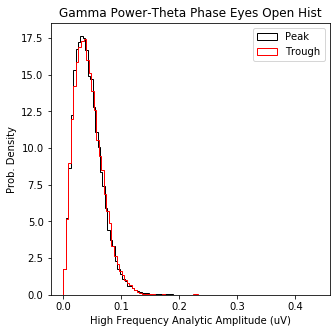

In [121]:
# Coupling between theta phase and gamma power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerOpen[thetapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerOpen[thetatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Theta Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


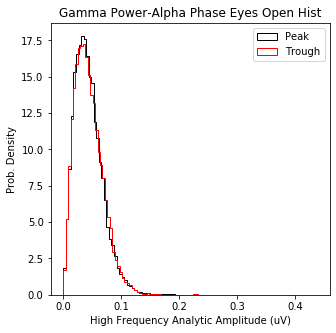

In [122]:
# Coupling between Alpha Phase and Gamma power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerOpen[alphapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerOpen[alphatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Alpha Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


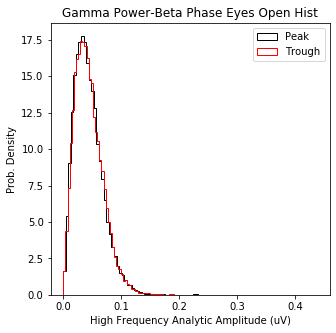

In [123]:
#Coupling between Beta Phase and Gamma Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerOpen[betapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerOpen[betatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Beta Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


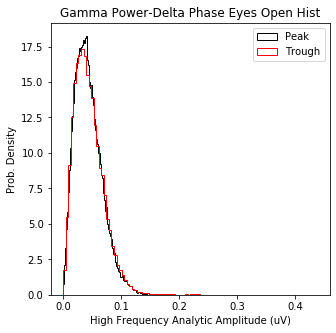

In [124]:
#Coupling between Delta Phase and Gamma Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerOpen[deltapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerOpen[deltatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Delta Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


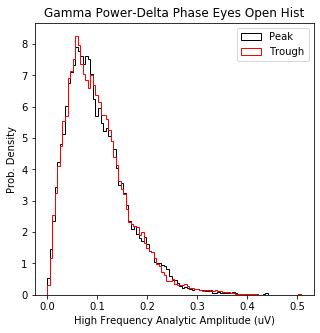

In [125]:
# Coupling betwen Alpha Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerOpen[alphapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerOpen[alphatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Delta Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


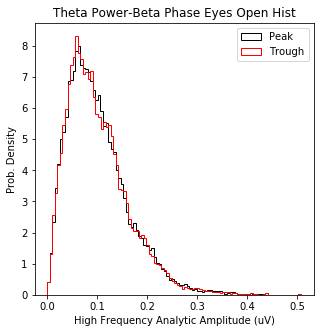

In [126]:
#Coupling between Beta Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerOpen[betapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerOpen[betatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Theta Power-Beta Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


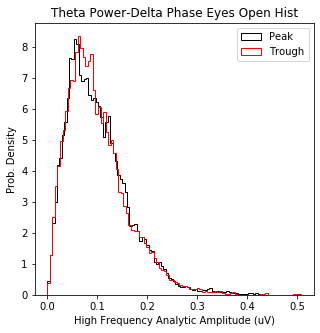

In [127]:
#Coupling between Delta Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerOpen[deltapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerOpen[deltatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Theta Power-Delta Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


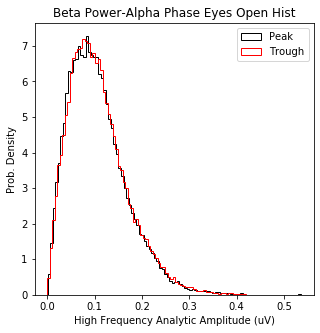

In [128]:
#Coupling betwee Alpha phase and Beta power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(beta_powerOpen[alphapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(beta_powerOpen[alphatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Beta Power-Alpha Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


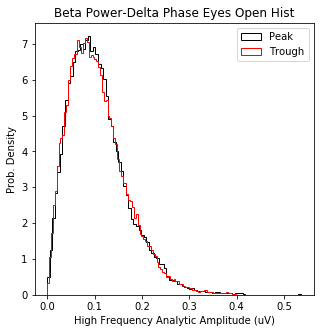

In [129]:
#Coupling between Delta Phase and Beta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(beta_powerOpen[deltapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(beta_powerOpen[deltatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Beta Power-Delta Phase Eyes Open Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


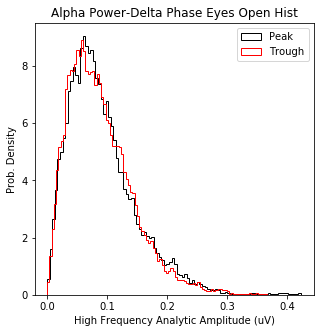

In [130]:
#Coupling between Delta Phase and Alpha Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(alpha_powerOpen[deltapeak_indsOpen]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(alpha_powerOpen[deltatrough_indsOpen]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Alpha Power-Delta Phase Eyes Open Hist')
plt.legend()

# PHASE AMP Coupling EYES CLOSED
Here we will look at the phase amplitude coupling of eyes closed channel waves.

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


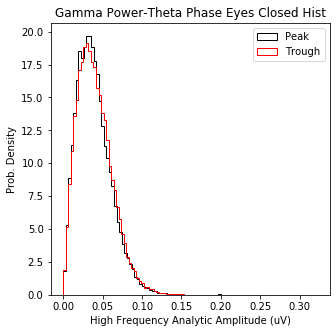

In [131]:
#Coupling between Theta Phase and gamma power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerClosed[thetapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerClosed[thetatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Theta Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


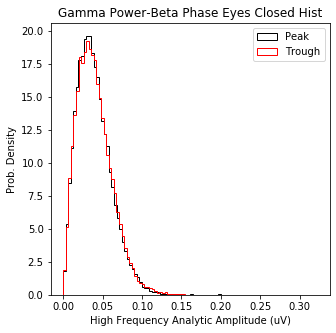

In [132]:
#Coupling between Beta Phase and Gamma Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerClosed[betapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerClosed[betatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Beta Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


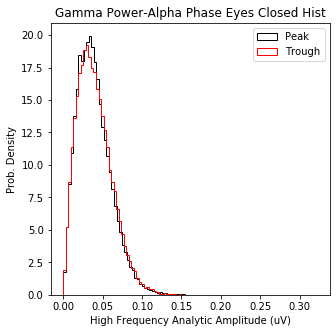

In [133]:
#Coupling between Alpha Phase and Gamma Phase
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerClosed[alphapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerClosed[alphatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Alpha Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


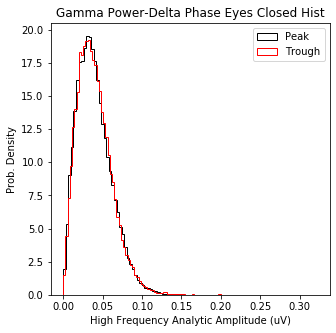

In [134]:
#Coupling between Delta Phase and Gamma Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerClosed[deltapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerClosed[deltatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Delta Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


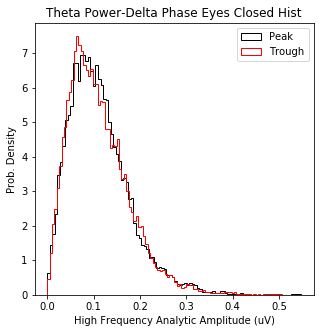

In [135]:
#Coupling between Delta Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerClosed[deltapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerClosed[deltatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Theta Power-Delta Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


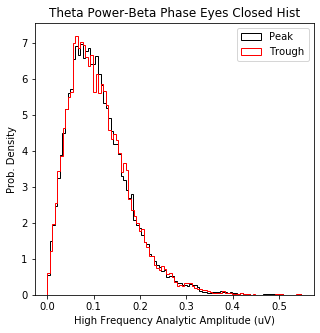

In [136]:
#Coupling between Beta Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerClosed[betapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerClosed[betatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Theta Power-Beta Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


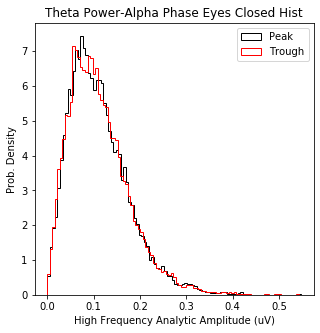

In [137]:
#Coupling between Alpha Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerClosed[alphapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerClosed[alphatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Theta Power-Alpha Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


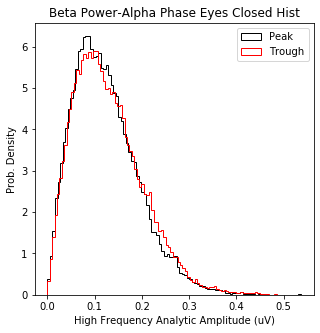

In [138]:
#Coupling between Alpha Phase and Beta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(beta_powerClosed[alphapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(beta_powerClosed[alphatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Beta Power-Alpha Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


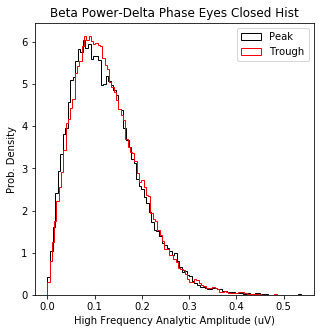

In [139]:
#Coupling between Delta Phase and Beta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(beta_powerClosed[deltapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(beta_powerClosed[deltatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Beta Power-Delta Phase Eyes Closed Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


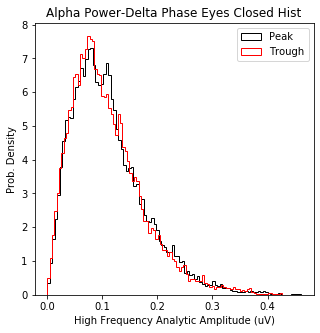

In [140]:
#Coupling between Delta Phase and Alpha Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(alpha_powerClosed[deltapeak_indsClosed]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(alpha_powerClosed[deltatrough_indsClosed]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Alpha Power-Delta Phase Eyes Closed Hist')
plt.legend()

# PHASE AMP COUPLING MONKEY ASLEEP
Here we will look at the phase amplitude coupling of sleeping channel waves.

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


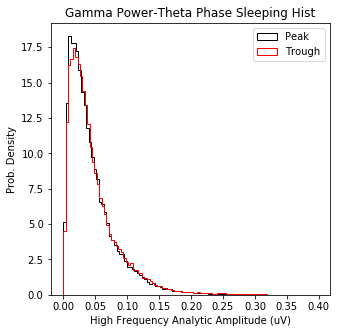

In [141]:
#Coupling between Theta Phase and Gamma Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerSleep[thetapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerSleep[thetatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Theta Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


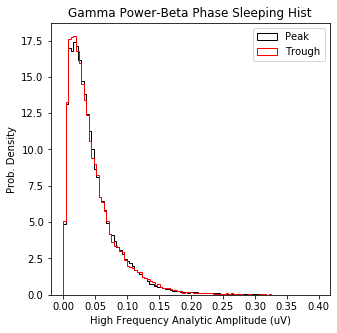

In [142]:
#Coupling between Beta Phase and Gamma Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerSleep[betapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerSleep[betatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Beta Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


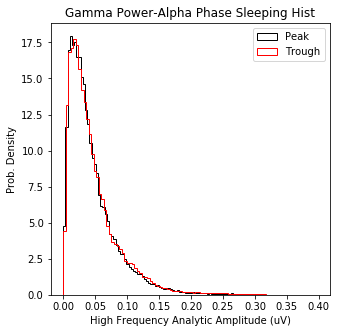

In [146]:
#Coupling between Alpha Phase and Gamma Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerSleep[alphapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerSleep[alphatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Alpha Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


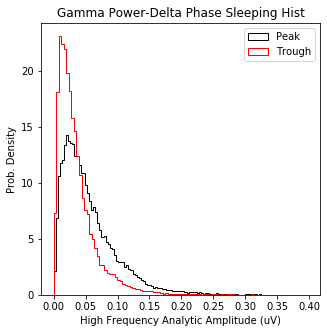

In [147]:
#Coupling between Delta Phase and Gamma Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(gamma_powerSleep[deltapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(gamma_powerSleep[deltatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Gamma Power-Delta Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


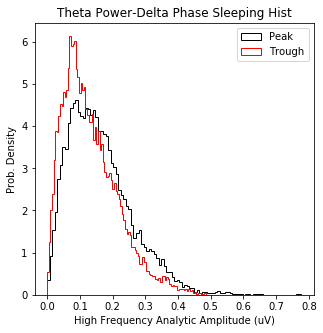

In [148]:
#Coupling between Delta Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerSleep[deltapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerSleep[deltatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Theta Power-Delta Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


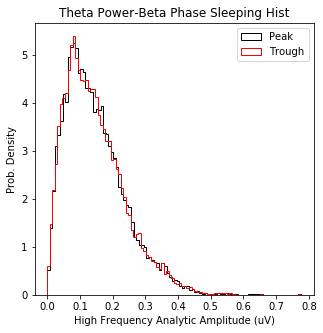

In [149]:
#Coupling between Beta Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerSleep[betapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerSleep[betatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Theta Power-Beta Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


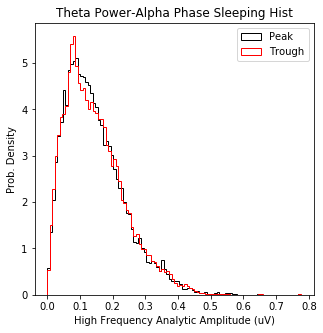

In [150]:
#Coupling between Alpha Phase and Theta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(theta_powerSleep[alphapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(theta_powerSleep[alphatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Theta Power-Alpha Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


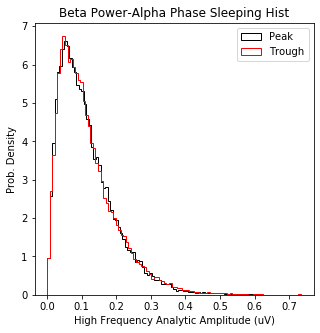

In [151]:
#Coupling between Alpha Phase and Beta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(beta_powerSleep[alphapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(beta_powerSleep[alphatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('High Frequency Analytic Amplitude (uV)'); plt.ylabel('Prob. Density');
plt.title('Beta Power-Alpha Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


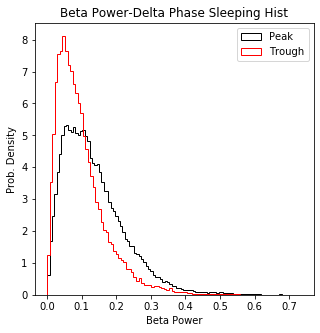

In [118]:
#Coupling between Delta Phase and Beta Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(beta_powerSleep[deltapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(beta_powerSleep[deltatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('Beta Power'); plt.ylabel('Prob. Density');
plt.title('Beta Power-Delta Phase Sleeping Hist')
plt.legend()

/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/daniellew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


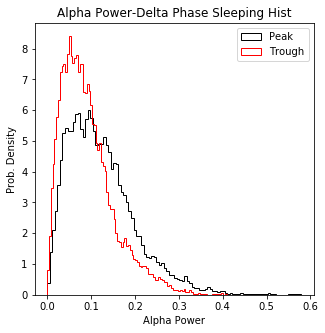

In [119]:
#Coupling between Delta Phase and Alpha Power
plt.figure(figsize=(5,5))
# complete the function call to plot the histogram
plt.hist(np.sqrt(alpha_powerSleep[deltapeak_indsSleep]), 100, color='k',normed=True, histtype='step', label='Peak');
plt.hist(np.sqrt(alpha_powerSleep[deltatrough_indsSleep]), 100, color='r',normed=True, histtype='step', label='Trough');
plt.xlabel('Alpha Power'); plt.ylabel('Prob. Density');
plt.title('Alpha Power-Delta Phase Sleeping Hist')
plt.legend()